In [36]:
# import packages
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from pathlib import Path
from sklearn.model_selection import train_test_split

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
# target column name is "found_helpful_percentage"
input_files = glob.glob('data/*')
dfs = []
for f in input_files:
    df = pd.read_json(f, lines=True)
    df.insert(0, 'title', Path(f).stem)
    dfs.append(df)
df_combined = pd.concat(dfs)
print(df_combined.columns)

Index(['title', 'total_game_hours_last_two_weeks', 'num_groups', 'orig_url',
       'num_badges', 'review_url', 'num_found_funny', 'review', 'date_updated',
       'num_workshop_items', 'date_posted', 'found_helpful_percentage',
       'num_voted_helpfulness', 'achievement_progress', 'profile_url',
       'num_found_helpful', 'steam_id_number', 'friend_player_level',
       'num_found_unhelpful', 'total_game_hours', 'username', 'num_guides',
       'rating', 'num_friends', 'num_screenshots', 'num_comments',
       'num_reviews', 'num_games_owned'],
      dtype='object')


In [3]:
# select only records that have significant amount of usefulness votes
print(len(df_combined.num_voted_helpfulness))
print(len(df_combined[df_combined.num_voted_helpfulness>10]))
print(len(df_combined[df_combined.num_voted_helpfulness>20]))
print(len(df_combined[df_combined.num_voted_helpfulness>30]))
# for now, choose 10 as the selection rule
df_sel = df_combined[df_combined.num_voted_helpfulness>10]

79437
9482
6279
5184


In [4]:
# df_review = df_sel[['review']]
df_review = df_sel['review']
df_target = df_sel['found_helpful_percentage']
X_train, X_test , y_train, y_test = train_test_split(df_review, df_target, test_size = 0.20)

In [5]:
# some (hyper)parameter settings
# ref: https://heartbeat.comet.ml/text-classification-using-long-short-term-memory-glove-embeddings-6894abb730e1
vocab_size = 1000
oov_token = '<OOV>'
max_length = 100
padding_type = 'post'
truncation_type = 'post'

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [7]:
word_index = tokenizer.word_index
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

In [8]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

In [9]:
# XGBoost regression

In [10]:
# download the pretrained GloVe pre-trained word vectors if not exists
# $ conda install -c conda-forge python-wget
import wget
model_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
out_dir = 'model/glove'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_fpn = os.path.join(out_dir, 'glove.6B.zip')
if not os.path.exists(out_fpn):
    model_file = wget.download(model_url, out=out_fpn)

In [11]:
# obtain the token for the zip file without unzip
import zipfile
unzipped_model = zipfile.ZipFile(out_fpn, 'r')
print(unzipped_model.namelist())

# extract the single file for use
# since extracting on the fly takes much much time...
ext_file = f'glove.6B.{max_length}d.txt'
ext_model_fpn = os.path.join(out_dir, ext_file)
if not os.path.exists(ext_model_fpn):
    unzipped_model.extract(ext_file, out_dir)

['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']


In [12]:
# load the pretrained vector
embeddings_index = {}
f = open(ext_model_fpn)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Different Models
Up to the previous cell, the training and test datasets are vectorized and ready to be input to a model.  
I'll attempt to try out the XGBoost model first.  
If time is allowed, I will play with LSTM.  

## XGBoost
A seemingly very nice article is found [here](https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html).  



In [13]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
'''
Use third party utilities.
Ref:
https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html
'''
from gensim.scripts.glove2word2vec import glove2word2vec
from pathlib import Path

word2vec_output_fpn = os.path.join('model/glove', Path(ext_model_fpn).stem + '.w2v')
if not os.path.exists(word2vec_output_fpn):
    glove2word2vec(ext_model_fpn, word2vec_output_fpn)

In [15]:
# load the converted word2vec model from glove
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(word2vec_output_fpn, binary=False)

# play around a bit
# Show a word embedding
print('King: ',model.get_vector('king'))
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('Most similar word to King + Woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

In [16]:
print(len(X_train),len(X_test))
# print(list(X_train)[0])
for review in X_train:
    print(review)
    break

7585 1897
Cheaters only trust me it's gross


In [17]:
# define a transformer class to engineer features
from sklearn.base import BaseEstimator, TransformerMixin

class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        print('Loading in word vectors...')
        self.word_vectors = model
        print('Finished loading in word vectors')
    def fit(self, data):
        return self
    def transform(self, data):
        # determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    # throws KeyError if word not found
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print('Numer of samples with no words found: %s / %s' % (emptycount, len(data)))
        return X

In [18]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the review embeddings for the train dataset
X_train_vec = vectorizer.fit_transform(list(X_train))
X_test_vec = vectorizer.fit_transform(list(X_test))

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 153 / 7585
Numer of samples with no words found: 45 / 1897


In [19]:
X_train_vec

array([[ 0.13729724,  0.18241251,  0.48040497, ..., -0.35816899,
         0.33158448,  0.22739248],
       [-0.21258388,  0.24014692,  0.33700874, ..., -0.14024556,
         0.39537361,  0.00507961],
       [-0.05782771,  0.25303122,  0.43826687, ..., -0.28705144,
         0.53069979,  0.21803182],
       ...,
       [-0.11633495,  0.13064913,  0.58796245, ..., -0.2134067 ,
         0.71337301,  0.26526523],
       [-0.21880999, -0.04215375,  0.70920503, ..., -0.13991925,
         0.58764249,  0.45243001],
       [-0.087279  , -0.18650866,  0.00195   , ..., -0.08145767,
         0.17842667,  0.08714867]])

In [20]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
regressor.fit(X_train_vec, y_train)
y_test_pred = regressor.predict(X_test_vec)

In [21]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
y_train_pred = regressor.predict(X_train_vec)
print('$r^2$', r2_score(y_test, y_test_pred))
print('mean absolute error', mean_absolute_error(y_test, y_test_pred))
print('mean absolute percentage error', mean_absolute_percentage_error(y_test, y_test_pred))


$r^2$ 0.2598040144266571
mean absolute error 0.10989497542521652
mean absolute percentage error 9567532934041.54


In [32]:
df_test_res = pd.DataFrame()
df_test_res['y_true'] = list(y_test)
df_test_res['y_pred'] = list(y_test_pred)
df_test_res['error'] = list(y_test_pred - y_test)
df_test_res['absolute error'] = np.abs(df_test_res.y_pred - df_test_res.y_true)

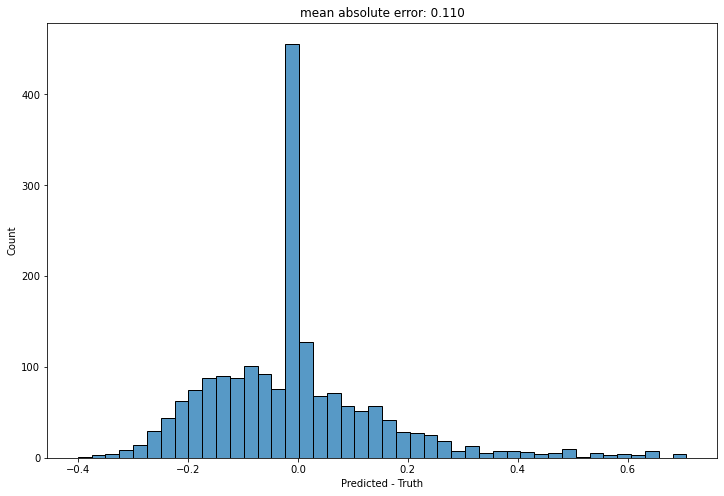

In [51]:
fig = plt.figure(figsize=(12, 8))
ax = sns.histplot(data=df_test_res, x='error')
ax.set_xlabel('Predicted - Truth')
ax.set_title('mean absolute error: {:.3f}'.format(mean_absolute_error(y_test, y_test_pred)))

out_dir = 'figures'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
ax.get_figure().savefig(os.path.join(out_dir, 'performance_error.png'))